**2. Exploratory Data Analysis**
=

***Advanced Methods of Artificial Vision - Final Project***

**Authors:** *Alejandro Araque Robles, Ander Bodegas Díez, Lucía Gonzalez Ratón y Gonzalo Sabando Alonso*

# 2.1. Data Loading

First we need to import all the packages that we are going to need for the project.

In [19]:
from google.colab import drive

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
import random
import pandas as pd

Then, we mount the drive to get access to the dataset.

In [20]:
drive.mount('/content/drive')
pathRoot = '/content/drive/MyDrive/Colab Notebooks/Admeav/FinalProjectAdmeav'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2.2. Data Exploration

Data is structured in two folders: benign and malignant. In each folder, ultrasound images are stored along with their masks, which can be more than one for each image. In this section we will explore these data.

- breast_ultrasound
  - benign
  - malignant

In [21]:
# Benign and malignant file paths
pathB = os.path.join(pathRoot, 'breast_ultrasound', 'benign')
pathM = os.path.join(pathRoot, 'breast_ultrasound', 'malignant')

# Benign and malignant file lists
listB = os.listdir(pathB)
listM = os.listdir(pathM)

# Benign and malignant image lists
listImgB = [x for x in listB if 'mask' not in x]
listImgM = [x for x in listM if 'mask' not in x]

# Benign and malignant masks lists
listMasB = [x for x in listB if 'mask' in x]
listMasM = [x for x in listM if 'mask' in x]

First of all, we're going to visualize some of the images and masks of the dataset.

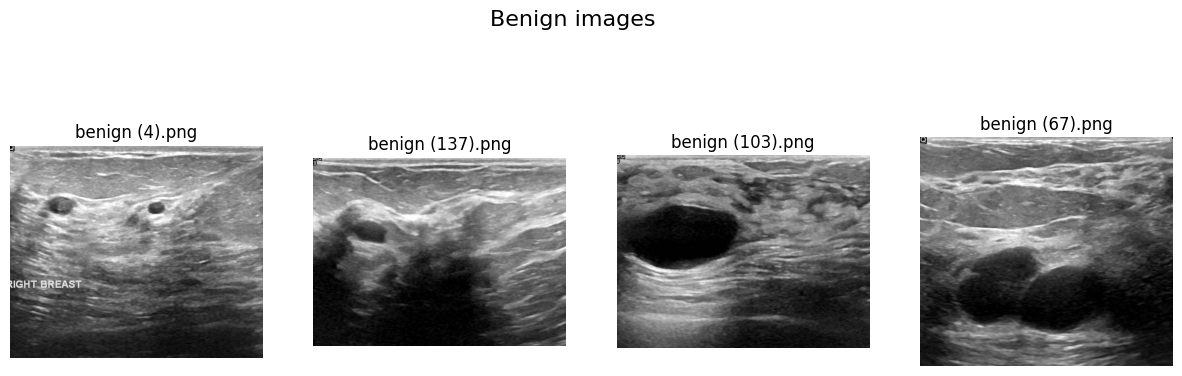

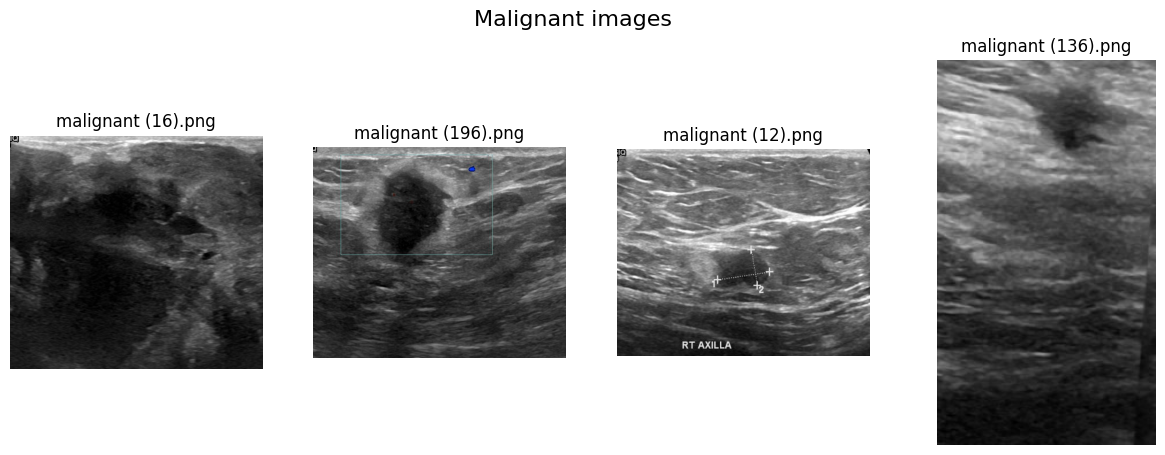

In [22]:
# Set seed for reproducibility
random.seed(42)

# Benign images
fig, ax = plt.subplots(1, 4, figsize = (15, 5))
plt.suptitle('Benign images', fontsize = 16)

for i in range(4):
  name = random.choice(listImgB)
  img = cv2.imread(os.path.join(pathB, name), flags = cv2.IMREAD_UNCHANGED)
  ax[i].imshow(img)
  ax[i].axis('off')
  ax[i].set_title(name)

# Malignant images
fig, ax = plt.subplots(1, 4, figsize = (15, 5))
plt.suptitle('Malignant images', fontsize = 16)

for i in range(4):
  name = random.choice(listImgM)
  img = cv2.imread(os.path.join(pathM, name), flags = cv2.IMREAD_UNCHANGED)
  ax[i].imshow(img)
  ax[i].axis('off')
  ax[i].set_title(name)

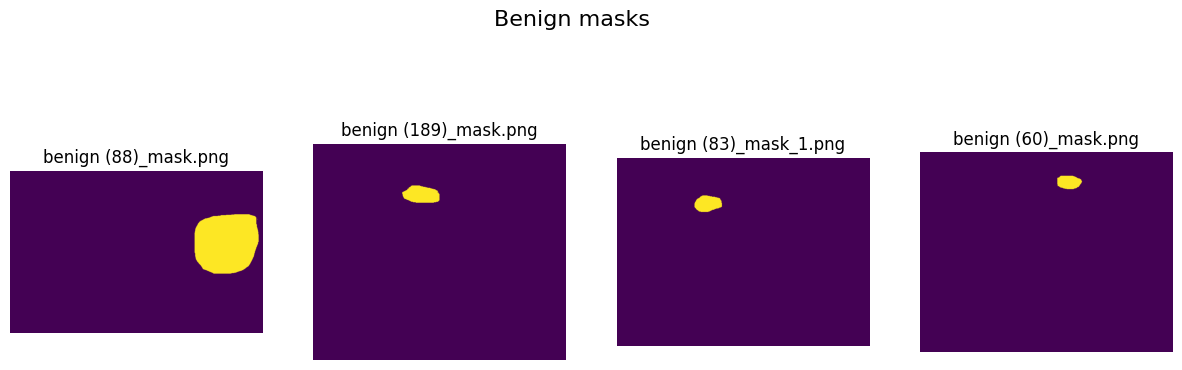

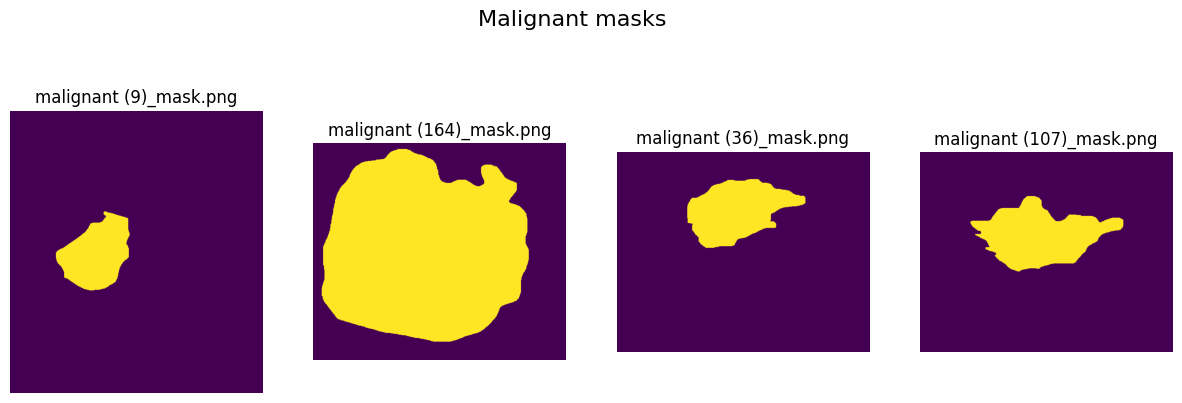

In [23]:
# Benign masks
fig, ax = plt.subplots(1, 4, figsize = (15, 5))
plt.suptitle('Benign masks', fontsize = 16)

for i in range(4):
  name = random.choice(listMasB)
  mas = cv2.imread(os.path.join(pathB, name), flags = cv2.IMREAD_UNCHANGED)
  ax[i].imshow(mas)
  ax[i].axis('off')
  ax[i].set_title(name)

# Malignant masks
fig, ax = plt.subplots(1, 4, figsize = (15, 5))
plt.suptitle('Malignant masks', fontsize = 16)

for i in range(4):
  name = random.choice(listMasM)
  mas = cv2.imread(os.path.join(pathM, name), flags = cv2.IMREAD_UNCHANGED)
  ax[i].imshow(mas)
  ax[i].axis('off')
  ax[i].set_title(name)

As we see, images seem grayscale with variable shapes, and some masks seem to cover a considerable part of the images, especially in the malignant samples. In addition, some images present annotations such as text or bounding boxes that may affect the segmentation model, although removing them is a difficult task. Let's give a detailed summary of the files in the dataset.

In [24]:
# Create structure of dataframe
strImg = {
  'IMAGE_NAME': [],
  'CLASS': [],
  'HEIGHT': [],
  'WIDTH': [],
  'N_CHANNELS': [],
  'DATA_TYPE': [],
  'N_MASKS': []
}
strMas = {
  'MASK_NAME': [],
  'CLASS': [],
  'HEIGHT': [],
  'WIDTH': [],
  'N_CHANNELS': [],
  'DATA_TYPE': [],
  'SHAPE_MATCH': [],
  'MIN_VALUE': [],
  'MAX_VALUE': [],
  'N_DISTINCT_VALUES': []
}

# Loop over benign and malignant images and masks
for path, listImg, listMas, cls in zip(
    [pathB, pathM],
    [listImgB, listImgM],
    [listMasB, listMasM],
    ['Benign', 'Malignant']
):
  for name in listImg:
    img = cv2.imread(os.path.join(path, name), cv2.IMREAD_UNCHANGED)
    H1, W1, C1 = img.shape
    strImg['IMAGE_NAME'].append(name)
    strImg['CLASS'].append(cls)
    strImg['HEIGHT'].append(H1)
    strImg['WIDTH'].append(W1)
    strImg['N_CHANNELS'].append(C1)
    strImg['DATA_TYPE'].append(img.dtype)

    listMasImg = [x for x in listMas if name[:-4] in x]
    strImg['N_MASKS'].append(len(listMasImg))

    for name in listMasImg:
      mas = cv2.imread(os.path.join(path, name), cv2.IMREAD_UNCHANGED)
      if len(mas.shape) == 2:
        H2, W2 = mas.shape
        C2 = 1
      else:
        H2, W2, C2 = mas.shape
      strMas['MASK_NAME'].append(name)
      strMas['CLASS'].append(cls)
      strMas['HEIGHT'].append(H2)
      strMas['WIDTH'].append(W2)
      strMas['N_CHANNELS'].append(C2)
      strMas['DATA_TYPE'].append(mas.dtype)
      strMas['SHAPE_MATCH'].append(1 if (H1 == H2) and (W1 == W2) else 0)
      strMas['MIN_VALUE'].append(mas.min())
      strMas['MAX_VALUE'].append(mas.max())
      strMas['N_DISTINCT_VALUES'].append(len(np.unique(mas)))

# Create dataframes
dfImg = pd.DataFrame(strImg)
dfMas = pd.DataFrame(strMas)

In [25]:
print(dfImg['DATA_TYPE'].unique())
print(dfMas['DATA_TYPE'].unique())

[dtype('uint8')]
[dtype('uint8')]


First, we can see that both images and masks are uint8 files.

In [26]:
print(dfImg[dfImg['CLASS'] == 'Benign'].describe())
print('\n')
print(dfImg[dfImg['CLASS'] == 'Malignant'].describe())

           HEIGHT        WIDTH  N_CHANNELS     N_MASKS
count  437.000000   437.000000       437.0  437.000000
mean   495.471396   613.386728         3.0    1.038902
std     78.141469   117.258102         0.0    0.205088
min    324.000000   315.000000         3.0    1.000000
25%    464.000000   554.000000         3.0    1.000000
50%    471.000000   563.000000         3.0    1.000000
75%    574.000000   706.000000         3.0    1.000000
max    719.000000  1028.000000         3.0    3.000000


           HEIGHT        WIDTH  N_CHANNELS     N_MASKS
count  210.000000   210.000000       210.0  210.000000
mean   494.014286   597.971429         3.0    1.004762
std     60.434668   125.221141         0.0    0.069007
min    332.000000   190.000000         3.0    1.000000
25%    463.000000   552.000000         3.0    1.000000
50%    474.000000   564.000000         3.0    1.000000
75%    554.000000   649.750000         3.0    1.000000
max    677.000000  1048.000000         3.0    2.000000


Regarding the images, the dataset is pretty unbalanced, with the number of benign images (437) doubling the number of malignant images (210). All of the images have 3 channels, with generally one mask per image and a variable shape, averaging 495x613 and 494x598 pixels in benign and malignant samples, respectively.

The low number of masks per image, which is the same as instances per image, suggests that a semantic segmentation approach is appropiate, since the class of each instance is the same within each image. In addition, a reshape to 512x512 pixels seems adequate, and weighting should be applied on the classification methods to account for the unbalanced class distribution.

In [27]:
print(dfMas[dfMas['CLASS'] == 'Benign'].describe())
print('\n')
print(dfMas[dfMas['CLASS'] == 'Malignant'].describe())

           HEIGHT        WIDTH  N_CHANNELS  SHAPE_MATCH  MIN_VALUE  MAX_VALUE  \
count  454.000000   454.000000  454.000000        454.0      454.0      454.0   
mean   496.229075   614.969163    1.013216          1.0        0.0      255.0   
std     78.017123   117.770117    0.198897          0.0        0.0        0.0   
min    324.000000   315.000000    1.000000          1.0        0.0      255.0   
25%    464.000000   554.000000    1.000000          1.0        0.0      255.0   
50%    471.000000   563.000000    1.000000          1.0        0.0      255.0   
75%    574.000000   726.000000    1.000000          1.0        0.0      255.0   
max    719.000000  1028.000000    4.000000          1.0        0.0      255.0   

       N_DISTINCT_VALUES  
count              454.0  
mean                 2.0  
std                  0.0  
min                  2.0  
25%                  2.0  
50%                  2.0  
75%                  2.0  
max                  2.0  


           HEIGHT        

Regarding the masks, all of them match their image shape, having two unique values: 0 and 255 for background and foreground, respectively. Surprisingly, some masks have more than one channel, let's explore them.


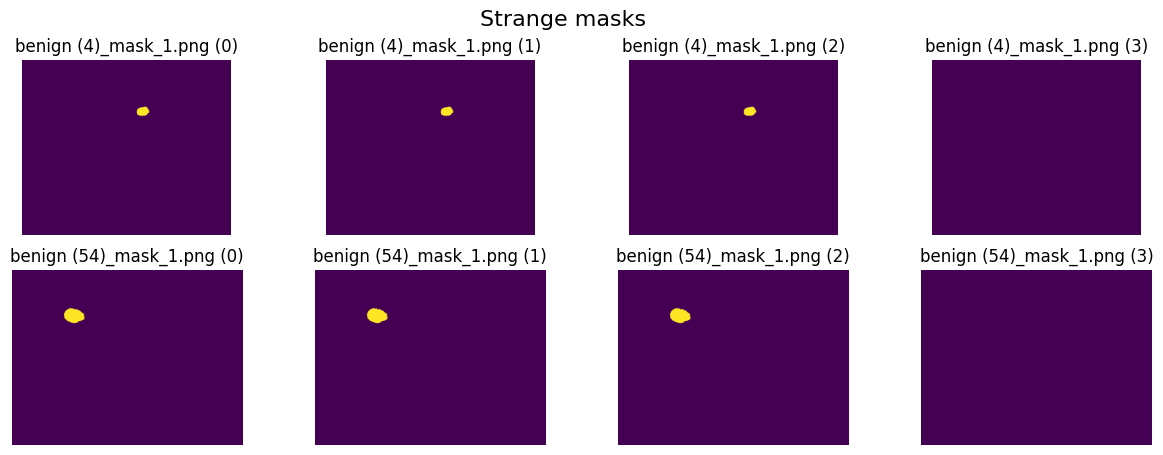

In [28]:
listStrange = dfMas[dfMas['N_CHANNELS'] > 1]['MASK_NAME']
fig, ax = plt.subplots(len(listStrange), 4, figsize = (15, 5))
plt.suptitle('Strange masks', fontsize = 16)
for i, name in enumerate(listStrange):
  mas = cv2.imread(os.path.join(pathB, name), cv2.IMREAD_UNCHANGED)
  for j in range(4):
    ax[i, j].imshow(mas[:, :, j])
    ax[i, j].axis('off')
    ax[i, j].set_title(f'{name} ({j})')

In [29]:
for i, name in enumerate(listStrange):
  mas = cv2.imread(os.path.join(pathB, name), cv2.IMREAD_UNCHANGED)
  print(f'-{name}')
  for j in range(1, 4):
    check = 'Yes' if np.prod(mas[:, :, 0] == mas[:, :, j]) == 1 else 'No'
    print(f'\t- Channel 0 equal to channel {j}? {check}')

-benign (4)_mask_1.png
	- Channel 0 equal to channel 1? Yes
	- Channel 0 equal to channel 2? Yes
	- Channel 0 equal to channel 3? No
-benign (54)_mask_1.png
	- Channel 0 equal to channel 1? Yes
	- Channel 0 equal to channel 2? Yes
	- Channel 0 equal to channel 3? No


As we can see, in these cases masks are composed by three equal channels and an empty fourth channel, so we can just keep the first channel.

# 2.3. Data Preprocessing and Dataset Generation

Putting all this exploratory analysis together, we're going to create a dataset to train, validate and test a segmentation model. Image preprocessing will consist in reshaping to 512x512 pixels with linear interpolation, while mask will be reshaped with nearest neighbour interpolation to mantain binary values. For the cases in which more than one instance is present, masks will be combined to create a unique mask. We will split the total dataset into three subsets for training (70%), validation (15%) and testing (15%), mantaining the original unbalanced class distribution. The dataset organization will be as follows:
- DATASET
  - TRAIN
    - IMAGES
    - MASKS
  - VALIDATION
    - IMAGES
    - MASKS
  - TEST
    - IMAGES
    - MASKS

In [30]:
# Set seed for reproducibility
random.seed(42)

# Loop over benign and malignant images and masks
for path, listImg, listMas in zip(
    [pathB, pathM],
    [listImgB, listImgM],
    [listMasB, listMasM]
):

  # Shuffle the list
  random.shuffle(listImg)
  N = len(listImg)

  # Calculate the sizes of each split
  sizeTrain = int(np.round(0.7 * N, 0))
  sizeVal = int(np.round(0.15 * N, 0))

  for i, name in enumerate(listImg):

    if i < sizeTrain:
      fol = 'TRAIN'
    elif i < sizeTrain + sizeVal:
      fol = 'VALIDATION'
    else:
      fol = 'TEST'

    # Read image
    img = cv2.imread(os.path.join(path, name), flags = cv2.IMREAD_UNCHANGED)

    # Create base mask
    masBase = np.zeros((img.shape[0], img.shape[1]), dtype = 'uint8')

    # Read masks for the selected image and add them
    listMasImg = [x for x in listMas if name[:-4] in x]
    for x in listMasImg:

      # Read mask
      mas = cv2.imread(os.path.join(path, x), flags = cv2.IMREAD_UNCHANGED)

      # Add additional mask to base mask, with the fix for strange masks
      if len(mas.shape) > 2:
        masBase = cv2.bitwise_or(src1 = masBase, src2 = mas[:, :, 0])
      else:
        masBase = cv2.bitwise_or(src1 = masBase, src2 = mas)

    # Resize image to 512x512 using linear interpolation
    img = cv2.resize(
      src = img,
      dsize = (512, 512),
      interpolation = cv2.INTER_LINEAR
    )

    # Resize mask to 512x512 using nearest neighbor interpolation
    mas = cv2.resize(
      src = mas,
      dsize = (512, 512),
      interpolation = cv2.INTER_NEAREST
    )

    # Save image and mask
    cv2.imwrite(
      os.path.join(pathRoot, 'DATASET', fol, 'IMAGES', name),
      img
    )
    cv2.imwrite(
      os.path.join(pathRoot, 'DATASET', fol, 'MASKS', name),
      mas
    )